# Group 22 - Random Forest & Decision Tree - Regression

# 1.0 Import Libraries

In [1]:
# ! pip install graphviz
# ! pip install pydotplus
from sklearn.tree import export_graphviz

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from urllib.request import urlopen
from sklearn.preprocessing import StandardScaler

from sklearn.externals.six import StringIO  
from IPython.display import Image  
#import pydotplus

# 2.0 Import Data

Given certain aspects of a house, provide an estimate to the property's sale price in dollars. 

Information of all features is provided in the attached text file. 

In [2]:
# load testing and training data provided in https://www.kaggle.com/c/house-prices-advanced-regression-techniques 
train_housing_data = pd.read_csv('train_housing.csv')
test_housing_data = pd.read_csv('test_housing.csv')

# Convert column of price into per dollar to per thousands of dollars
train_housing_data['SalePrice']= train_housing_data['SalePrice'].apply(lambda x: x/1000)

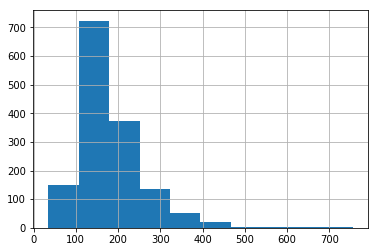

In [3]:
# Plot distribution of target column
train_housing_data['SalePrice'].hist()

In [4]:
# Merge provided training and test file together, excluding the sale price
merged_data = pd.concat((train_housing_data.loc[:,'MSSubClass':'SaleCondition'],
                       test_housing_data.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
merged_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
# Check for empty data
for parameter in merged_data:
    print(parameter,':', merged_data[parameter].dtypes,  ',', merged_data[parameter].hasnans, ',', merged_data[parameter].isna().sum())
    
print('There were', len(merged_data.columns), 'unique features')

MSSubClass : int64 , False , 0
MSZoning : object , True , 4
LotFrontage : float64 , True , 486
LotArea : int64 , False , 0
Street : object , False , 0
Alley : object , True , 2721
LotShape : object , False , 0
LandContour : object , False , 0
Utilities : object , True , 2
LotConfig : object , False , 0
LandSlope : object , False , 0
Neighborhood : object , False , 0
Condition1 : object , False , 0
Condition2 : object , False , 0
BldgType : object , False , 0
HouseStyle : object , False , 0
OverallQual : int64 , False , 0
OverallCond : int64 , False , 0
YearBuilt : int64 , False , 0
YearRemodAdd : int64 , False , 0
RoofStyle : object , False , 0
RoofMatl : object , False , 0
Exterior1st : object , True , 1
Exterior2nd : object , True , 1
MasVnrType : object , True , 24
MasVnrArea : float64 , True , 23
ExterQual : object , False , 0
ExterCond : object , False , 0
Foundation : object , False , 0
BsmtQual : object , True , 81
BsmtCond : object , True , 82
BsmtExposure : object , True , 82


In [7]:
# convert categorical data to numerics
merged_data = pd.get_dummies(merged_data)

In [8]:
print('After getting dummies there were', len(merged_data.columns), 'unique features')

After getting dummies there were 288 unique features


In [9]:
# remove NaN values and estimate with interpolated values
merged_data = merged_data.fillna(merged_data.interpolate())

# 2.0 Split Data into Training and Test

In [10]:
X_features_train_file = merged_data[:len(train_housing_data)]
X_features_test_file = merged_data[:len(test_housing_data)]
y_train_file = train_housing_data['SalePrice']/1000

In [11]:
# Split to training and test
X_train, X_test, y_train, y_test = train_test_split(X_features_train_file, y_train_file, test_size = 0.30,random_state = 42)

In [12]:
# Define functions that will be used for all models

def bias(y_predict,y):
    y_predict = np.array(y_predict)
    return np.average(np.power((y_predict-y),2))

def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

# from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Decision Tree Regression

### Optimize Model using Grid Search

In [13]:
# Create instance of a DecisionTreeRegressor
fit_dtr = DecisionTreeRegressor(random_state=42)
fit_dtr

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [14]:
# Perform gridsearch to determine optimal parameters
# Grid search
param_dist = { 
        "max_depth"      : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        "max_features"      : ["sqrt", "log2", None],
        "min_samples_leaf" : [2, 4, 8, 10, 12, 14]
        }
cv_RF_reg = GridSearchCV(fit_dtr, cv = 5, param_grid=param_dist)
cv_RF_reg.fit(X_train, y_train)
print(cv_RF_reg.best_params_)

{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8}


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
fit_dtr.set_params(max_depth= 45, 
                   max_features= None, 
                   min_samples_leaf= 8)

DecisionTreeRegressor(criterion='mse', max_depth=45, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [16]:
fit_dtr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=45, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [17]:
print('Accuracy of decision tree classifier on Train set: {:.3f}'.format(fit_dtr.score(X_train, y_train)))

Accuracy of decision tree classifier on Train set: 0.877


In [18]:
print('Accuracy of decision tree classifier on Test set: {:.3f}'.format(fit_dtr.score(X_test, y_test)))

Accuracy of decision tree classifier on Test set: 0.746


In [19]:
# cross validation with cv = 5
scores_DT_regressor = cross_val_score(fit_dtr, X_features_train_file, y_train_file, cv = 5)
ave_score_DT_regressor = np.mean(scores_DT_regressor)*100
print('The average score using CV is %.2f%%' % ave_score_DT_regressor)

The average score using CV is 78.04%


### Max-Depth Tuning Example

In [20]:
# Change hyperparamters to see effect on bias and variance
max_depth_DT_regression = np.arange(2,50)
accuracy_DT_regression_score_list = []
bias_DT_regression_list = []
var_DT_regression_list = []
total_DT_regression_list = []
err_DT_regression_list_test = []
err_DT_regression_list_training = []
err_tot_DT_regression_list = []
cv_error_DT_regression = []
score_DT_regression_list_test = []
score_DT_regression_list_training = []

model_DT_regressor = DecisionTreeRegressor(random_state=42)

for entry in max_depth_DT_regression:
    # model fit and predict
    model_DT_regressor.set_params(max_depth=entry)
    model_DT_regressor.fit(X_train, y_train)
    predicted_y_DT_regressor_test = model_DT_regressor.predict(X_test)
    predicted_y_DT_regressor_train = model_DT_regressor.predict(X_train)
    # bias and variance estimate
    bias_variable = bias(predicted_y_DT_regressor_test, y_test)
    variance_variable = variance(predicted_y_DT_regressor_test)
    bias_DT_regression_list.append(bias_variable)
    var_DT_regression_list.append(variance_variable)
    total_DT_regression = bias_variable + variance_variable
    total_DT_regression_list.append(total_DT_regression)
    # training and test estimate
    err_DT_test_variable =mean_squared_error(y_test,predicted_y_DT_regressor_test)
    err_DT_training_variable = mean_squared_error(y_train, predicted_y_DT_regressor_train)
    err_DT_tot_variable = err_DT_test_variable + err_DT_training_variable
    err_DT_regression_list_test.append(err_DT_test_variable)
    err_DT_regression_list_training.append(err_DT_training_variable)
    err_tot_DT_regression_list.append(err_DT_tot_variable)
    # average test accuracy
    cv_error_DT_regression.append(np.mean(cross_val_score(model_DT_regressor, X_features_train_file, y_train_file, cv = 5)))
    # R2 accuracy score
    score_DT_regression_list_test.append(model_DT_regressor.score(X_test, y_test))
    score_DT_regression_list_training.append(model_DT_regressor.score(X_train, y_train))

#### Plot plot bias and variance estimated on the test set

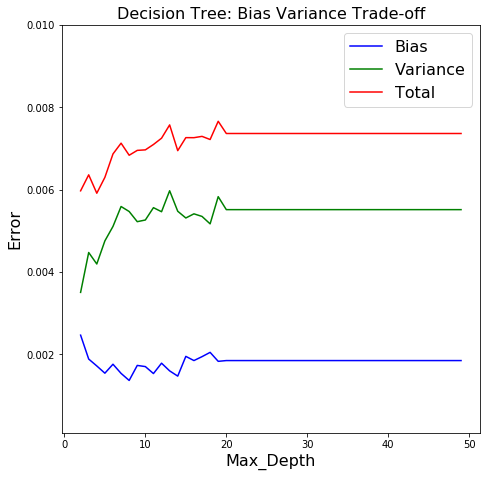

In [21]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_regression, bias_DT_regression_list,color = 'b')
plt.plot(max_depth_DT_regression, var_DT_regression_list,color = 'g')
plt.plot(max_depth_DT_regression, total_DT_regression_list,color = 'r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize = 16)
plt.title('Decision Tree: Bias Variance Trade-off',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0.0001,0.01)
plt.show()

#### Plot accuracy score to compare training performace with test performance

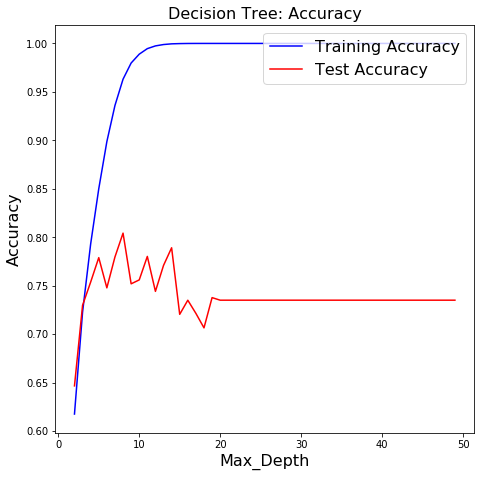

In [22]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_regression, score_DT_regression_list_training,color = 'b')
plt.plot(max_depth_DT_regression, score_DT_regression_list_test,color = 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize = 16)
plt.title('Decision Tree: Accuracy',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
#plt.ylim(0.5,1.025)
plt.show()

#### An alternative way to gauge the bias and variance of a model is to minimise the combined error on testing predictions and training predictions. 

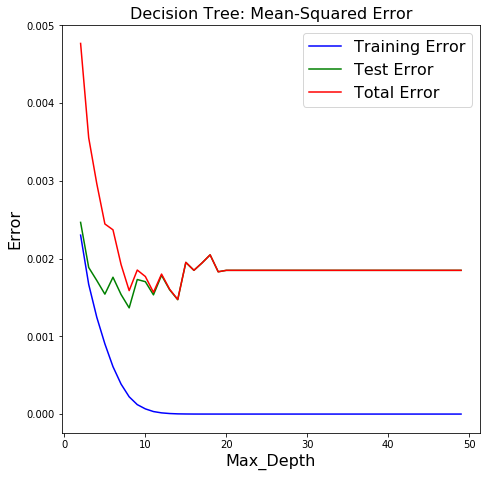

In [23]:
# Plot test error and training error with respect to depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_regression, err_DT_regression_list_training,color = 'b')
plt.plot(max_depth_DT_regression, err_DT_regression_list_test,color = 'g')
plt.plot(max_depth_DT_regression, err_tot_DT_regression_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Decision Tree: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
#plt.ylim(0,0.01)
plt.show()

#### Cross validation gives a better estimate of test accuracy but we lose information on training accuracy

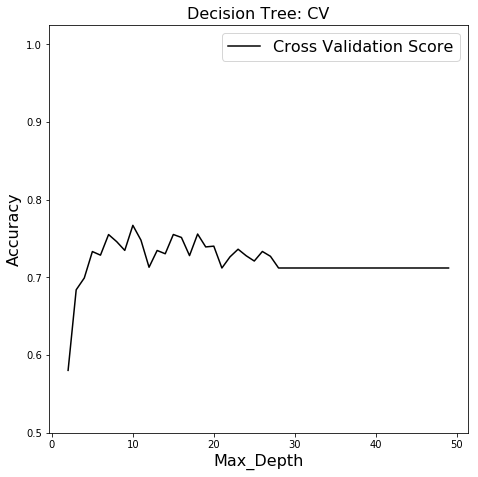

In [24]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_regression, cv_error_DT_regression,color='k')
plt.legend(['Cross Validation Score'], loc='upper right',fontsize=16)
plt.title('Decision Tree: CV',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

In [25]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

# Random Forest Regression

### Optimize model using grid search

In [26]:
RF_regressor = RandomForestRegressor(random_state=42)
RF_regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
# Grid search
param_dist = { 
              "n_estimators" : [10, 20, 30, 40, 50,60],
              'max_depth': [2, 5, 10, 20],
              'max_features': ['sqrt', 'log2'],   
              'min_samples_leaf' : [2, 4, 8,10,12,14],
              'criterion': ['mae', 'mse']
        }

model_RF_regressor = RandomForestRegressor(n_jobs = -1)
cv_RF_reg = GridSearchCV(model_RF_regressor, cv = 5, param_grid=param_dist)
cv_RF_reg.fit(X_train, np.ravel(y_train))
print(cv_RF_reg.best_params_)

{'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
RF_regressor.set_params(max_depth= 20, 
                        max_features= 'sqrt', 
                        min_samples_leaf= 2, 
                        n_estimators=60, 
                        oob_score = True,
                        criterion = 'mse')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [29]:
RF_regressor.fit(X_features_train_file, np.ravel(y_train_file))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [30]:
y_test_file = RF_regressor.predict(X_features_test_file)

In [31]:
accuracy_RF_regressor = RF_regressor.score(X_features_train_file, y_train_file)
accuracy_RF_regressor

0.9422710849539102

### Cross Validation vs OOB

In [32]:
# Out-of-Bag score 
ave_oob_score_RF_best_classifier = (RF_regressor.oob_score_)*100
print('The average score using Out-of-Bag estimate is %.2f%%' % ave_oob_score_RF_best_classifier)

The average score using Out-of-Bag estimate is 82.94%


In [33]:
# cross validation with cv = 5
scores_RF_regressor = cross_val_score(RF_regressor, X_features_train_file, y_train_file, cv = 5)
ave_score_RF_regressor = np.mean(scores_RF_regressor)*100
print('The average score using CV is %.2f%%' % ave_score_RF_regressor)

The average score using CV is 83.95%


### Max_depth tuning example

In [34]:
# Change hyperparamters(max_depth) to see effect on bias and variance
max_depth_RF_regression = np.arange(2,50)
bias_RF_regression_depth_list = []
var_RF_regression_depth_list = []
total_RF_regression_depth_list = []
err_RF_regression_list_test = []
err_RF_regression_list_training = []
err_tot_RF_regression_list = []
cv_error_RF_regression = []
oob_error_RF_regression = []
score_RF_regression_depth_list_test = []
score_RF_regression_depth_list_training = []

model_RF_regressor = RandomForestRegressor(random_state=42,oob_score=True)
model_RF_regressor.set_params(max_depth= 20, 
                        max_features= 'sqrt',  
                        n_estimators=20, 
                        oob_score = True,
                        criterion = 'mse')

for entry in max_depth_RF_regression:
    # 
    model_RF_regressor.set_params(max_depth=entry)
    model_RF_regressor.fit(X_train,  np.ravel(y_train))
    predicted_y_RF_regressor_test = model_RF_regressor.predict(X_test)
    predicted_y_RF_regressor_train = model_RF_regressor.predict(X_train)
    bias_variable = bias(predicted_y_RF_regressor_test, y_test)
    variance_variable = variance(predicted_y_RF_regressor_test)
    bias_RF_regression_depth_list.append(bias_variable)
    var_RF_regression_depth_list.append(variance_variable)
    total_RF_regression = bias_variable + variance_variable
    total_RF_regression_depth_list.append(total_RF_regression)
    # training and test estimate
    err_RF_test_variable =mean_squared_error(y_test,predicted_y_RF_regressor_test)
    err_RF_training_variable = mean_squared_error(y_train, predicted_y_RF_regressor_train)
    err_RF_tot_variable = err_RF_test_variable + err_RF_training_variable
    err_RF_regression_list_test.append(err_RF_test_variable)
    err_RF_regression_list_training.append(err_RF_training_variable)
    err_tot_RF_regression_list.append(err_RF_tot_variable)
    # average test accuracy
    cv_error_RF_regression.append(np.mean(cross_val_score(model_RF_regressor, X_features_train_file, y_train_file, cv = 5)))
    oob_error_RF_regression.append(model_RF_regressor.oob_score_)
    # fraction of accurate labels generated
    score_RF_regression_depth_list_test.append(model_RF_regressor.score(X_test, y_test))
    score_RF_regression_depth_list_training.append(model_RF_regressor.score(X_train, y_train))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

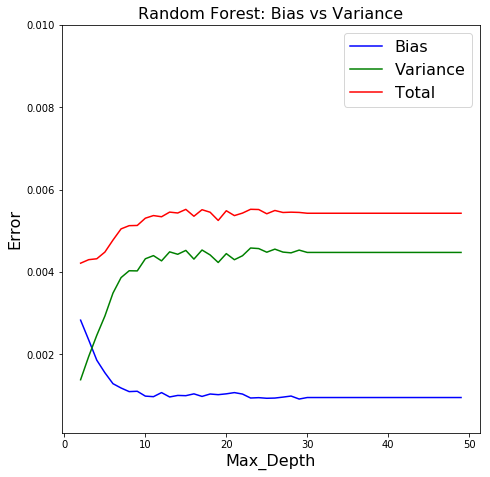

In [35]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_regression, bias_RF_regression_depth_list,color = 'b')
plt.plot(max_depth_RF_regression, var_RF_regression_depth_list,color = 'g')
plt.plot(max_depth_RF_regression, total_RF_regression_depth_list,color = 'r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Bias vs Variance',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0.0001,0.01)
plt.show()

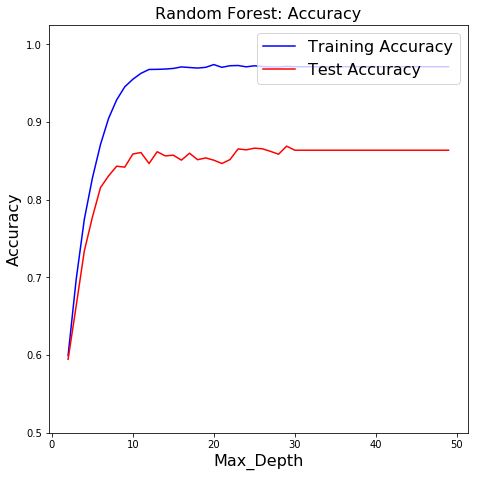

In [36]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_regression, score_RF_regression_depth_list_training,color = 'b')
plt.plot(max_depth_RF_regression, score_RF_regression_depth_list_test,color = 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Accuracy',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0.5,1.025)
plt.show()

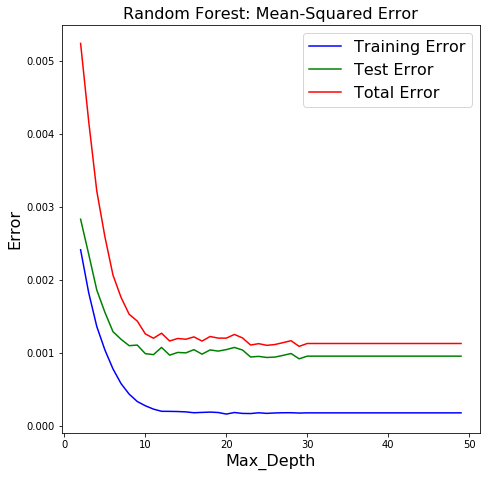

In [37]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_regression, err_RF_regression_list_training,color = 'b')
plt.plot(max_depth_RF_regression, err_RF_regression_list_test,color = 'g')
plt.plot(max_depth_RF_regression, err_tot_RF_regression_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
#plt.ylim(0,0.01)
plt.show()

#### Comparison of cross validation and OOB score reveals similar accuracy estimates

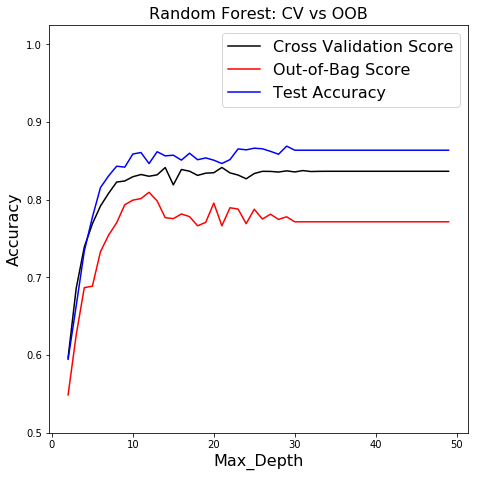

In [38]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_regression, cv_error_RF_regression,color='k')
plt.plot(max_depth_RF_regression, oob_error_RF_regression,color='r')
plt.plot(max_depth_RF_regression, score_RF_regression_depth_list_test,color = 'b')
plt.legend(['Cross Validation Score', 'Out-of-Bag Score','Test Accuracy'], loc='upper right',fontsize=16)
plt.title('Random Forest: CV vs OOB',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

### N-estimator tuning

In [ ]:
# Change hyperparamters(n_estimators) to see effect on bias and variance
n_estimator_RF_regression = np.arange(10,60)
bias_RF_regression_trees_list = []
var_RF_regression_trees_list = []
total_RF_regression_trees_list = []
err_RF_regression_list_test = []
err_RF_regression_list_training = []
err_tot_RF_regression_list = []
cv_error_RF_regression = []
oob_error_RF_regression = []
score_RF_regression_trees_list_test = []
score_RF_regression_trees_list_training = []

model_RF_regressor = RandomForestRegressor(random_state=42,oob_score = True)

for entry in n_estimator_RF_regression:
    
    model_RF_regressor.set_params(n_estimators=entry)
    model_RF_regressor.fit(X_train, np.ravel(y_train))
    
    predicted_y_RF_regressor_test = model_RF_regressor.predict(X_test)
    predicted_y_RF_regressor_train = model_RF_regressor.predict(X_train)
    bias_variable = bias(predicted_y_RF_regressor_test, y_test)
    variance_variable = variance(predicted_y_RF_regressor_test)
    bias_RF_regression_trees_list.append(bias_variable)
    var_RF_regression_trees_list.append(variance_variable)
    total_RF_regression = bias_variable + variance_variable
    total_RF_regression_trees_list.append(total_RF_regression)
    # training and test estimate
    err_RF_test_variable =mean_squared_error(y_test,predicted_y_RF_regressor_test)
    err_RF_training_variable = mean_squared_error(y_train, predicted_y_RF_regressor_train)
    err_RF_tot_variable = err_RF_test_variable + err_RF_training_variable
    err_RF_regression_list_test.append(err_RF_test_variable)
    err_RF_regression_list_training.append(err_RF_training_variable)
    err_tot_RF_regression_list.append(err_RF_tot_variable)
    # average test accuracy
    cv_error_RF_regression.append(np.mean(cross_val_score(model_RF_regressor, X_features_train_file, y_train_file, cv = 5)))
    oob_error_RF_regression.append(model_RF_regressor.oob_score_)
    
    score_RF_regression_trees_list_test.append(model_RF_regressor.score(X_test, y_test))
    score_RF_regression_trees_list_training.append(model_RF_regressor.score(X_train, y_train))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

In [ ]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimator_RF_regression, bias_RF_regression_trees_list,color = 'b')
plt.plot(n_estimator_RF_regression, var_RF_regression_trees_list,color = 'g')
plt.plot(n_estimator_RF_regression, total_RF_regression_trees_list,color = 'r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize = 16)
plt.title('Bias vs Variance',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('N_estimators',fontsize = 16)
plt.show()

In [ ]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimator_RF_regression, err_RF_regression_list_training,color = 'b')
plt.plot(n_estimator_RF_regression, err_RF_regression_list_test,color = 'g')
plt.plot(n_estimator_RF_regression, err_tot_RF_regression_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('N_estimators',fontsize = 16)
plt.ylim(0,0.01)
plt.show()

In [ ]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimator_RF_regression, cv_error_RF_regression,color='b')
plt.plot(n_estimator_RF_regression, oob_error_RF_regression,color='r')
plt.legend(['Cross Validation Score', 'Out-of-Bag Score'], loc='upper right',fontsize=16)
plt.title('Random Forest: CV vs OOB',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('N_estimators',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

In [ ]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimator_RF_regression, score_RF_regression_trees_list_training,color = 'b')
plt.plot(n_estimator_RF_regression, score_RF_regression_trees_list_test,color = 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize = 16)
plt.title('Accuracy',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('N_estimators',fontsize = 16)
plt.ylim(0.5,1.025)
plt.show()

# Variable Importance

In [51]:
importances_rf = RF_regressor.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
names = X_features_train_file.columns.tolist()

In [52]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")

    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1,
                                         names_index[indices[i]],
                                         importance[indices[f]]))

In [53]:
names_index = names
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. The feature 'OverallQual' has a Mean Decrease in Gini of 0.119863
2. The feature 'GrLivArea' has a Mean Decrease in Gini of 0.074938
3. The feature 'TotalBsmtSF' has a Mean Decrease in Gini of 0.058842
4. The feature 'GarageArea' has a Mean Decrease in Gini of 0.047903
5. The feature '1stFlrSF' has a Mean Decrease in Gini of 0.042404
6. The feature 'ExterQual_TA' has a Mean Decrease in Gini of 0.035145
7. The feature 'YearBuilt' has a Mean Decrease in Gini of 0.027916
8. The feature 'BsmtQual_Ex' has a Mean Decrease in Gini of 0.027568
9. The feature 'GarageCars' has a Mean Decrease in Gini of 0.026418
10. The feature 'LotArea' has a Mean Decrease in Gini of 0.026382
11. The feature '2ndFlrSF' has a Mean Decrease in Gini of 0.025269
12. The feature 'KitchenQual_TA' has a Mean Decrease in Gini of 0.024431
13. The feature 'BsmtFinSF1' has a Mean Decrease in Gini of 0.023557
14. The feature 'GarageYrBlt' has a Mean Decrease in Gini of 0.022365
15. The feature 'ExterQua

In [54]:
def variable_importance_plot(importance, indices, top= 20, Fontsize = 16):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order

    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index[0:20]))

    importance_desc = sorted(importance[0:20])
    feature_space = []
    for i in range(top-1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.title('Feature importances for Random Forest Model\
    \nHeart Disease',fontsize = Fontsize)
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space,fontsize = 10)

    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini',fontsize = Fontsize)
    plt.ylabel('Feature',fontsize = Fontsize)

    plt.show()
    plt.close()

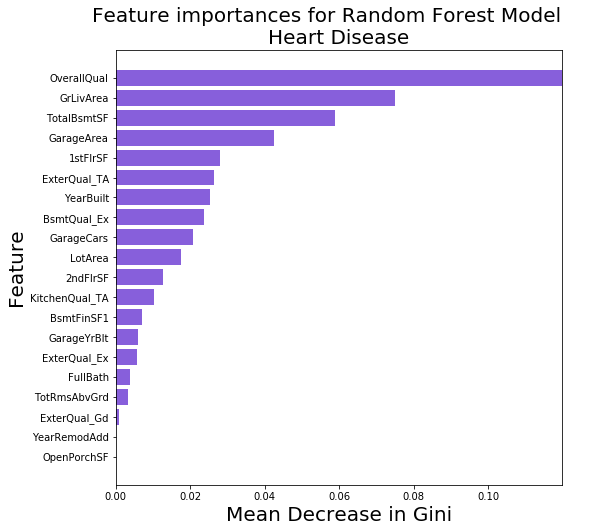

In [55]:
variable_importance_plot(importances_rf, indices_rf, top=20, Fontsize = 20)